<a href="https://colab.research.google.com/github/azfarkhoja305/GANs/blob/main/TGen_CnnD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Code adopted from https://pytorch.org/tutorials/beginner/dcgan_faces_tutorial.html

Calculates FID score in PyTorch

In [1]:
import os
import sys
from pathlib import Path
import functools 
import math
import pdb

Path.ls = lambda x: list(x.iterdir())

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
import torchvision.utils as vutils
from torchsummary import summary

In [ ]:
!git clone https://github.com/azfarkhoja305/GANs.git

In [3]:
if Path('./GANs').exists():
    sys.path.insert(0,'./GANs')

In [ ]:
!python ./GANs/create_fid_stats.py -d cifar_10 -t False

In [4]:
from datasets import ImageDataset
from utils.utils import check_gpu, display_images

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
device = check_gpu()
print(f'Using device: {device}')

Using device: cuda


In [19]:
from models.transformer_generator import TGenerator

Gen = TGenerator(latent_dims=1024).to(device)
# summary(Gen,(1024,))

In [8]:
from models.discriminator import Discriminator

Dis = Discriminator().to(device)
summary(Dis,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 32, 32]             432
         LeakyReLU-2           [-1, 16, 32, 32]               0
            Conv2d-3           [-1, 32, 16, 16]           8,192
         LeakyReLU-4           [-1, 32, 16, 16]               0
       BatchNorm2d-5           [-1, 32, 16, 16]              64
            Conv2d-6             [-1, 64, 8, 8]          32,768
         LeakyReLU-7             [-1, 64, 8, 8]               0
       BatchNorm2d-8             [-1, 64, 8, 8]             128
            Conv2d-9            [-1, 128, 4, 4]         131,072
        LeakyReLU-10            [-1, 128, 4, 4]               0
      BatchNorm2d-11            [-1, 128, 4, 4]             256
           Conv2d-12            [-1, 256, 1, 1]         524,288
           Linear-13                    [-1, 1]             256
Total params: 697,456
Trainable params:

In [9]:
dataset =  ImageDataset('cifar_10', batch_sz = 64)

Files already downloaded and verified


In [10]:
loss_fn = nn.BCEWithLogitsLoss()
real_label = 1.
fake_label = 0.
latent_dims = 1024
fixed_noise = torch.randn(64, latent_dims, device=device)
lr,beta1 = 1e-4, 0
optG = optim.AdamW(Gen.parameters(), lr=lr, betas=(beta1, 0.999))
optD = optim.AdamW(Dis.parameters(), lr=lr, betas=(beta1, 0.999))

In [11]:
img_list = []
G_losses = []
D_losses = []
iters = 0

# Number of training epochs
num_epochs = 10

In [12]:
for epoch in range(num_epochs):
    for i, data in enumerate(dataset.train_loader):

        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        Dis.zero_grad()
        # Format batch
        real = data[0].to(device)
        b_size = real.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        # Forward pass real batch through D
        output = Dis(real).view(-1)
        # Calculate loss on all-real batch
        errD_real = loss_fn(output,label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = torch.sigmoid(output).mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, latent_dims, device=device)
        # Generate fake image batch with G
        fake = Gen(noise)
        label = torch.full_like(label, fake_label)
        # Classify all fake batch with D
        # pdb.set_trace()
        output = Dis(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = loss_fn(output, label)
        # Calculate the gradients for this batch
        errD_fake.backward()
        D_G_z1 = torch.sigmoid(output).mean().item()
        # Add the gradients from the all-real and all-fake batches
        errD = errD_real + errD_fake
        # Update D
        optD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        Gen.zero_grad()
        label = torch.full_like(label,real_label) # fake labels are real for generator cost
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = Dis(fake).view(-1)
        # Calculate G's loss based on this output
        errG = loss_fn(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = torch.sigmoid(output).mean().item()
        # Update G
        optG.step()

        # Output training stats
        if (i+1) %700 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                % (epoch, num_epochs, i, len(dataset.train_loader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))
        
        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 1000 == 0) or ((epoch == num_epochs-1) and (i == len(dataset.train_loader)-1)):
            with torch.no_grad():
                fake = Gen(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters +=1
             

[0/10][699/782]	Loss_D: 0.6130	Loss_G: 2.7893	D(x): 0.7137	D(G(z)): 0.0741 / 0.1101
[1/10][699/782]	Loss_D: 0.5154	Loss_G: 3.3554	D(x): 0.8469	D(G(z)): 0.2028 / 0.0617
[2/10][699/782]	Loss_D: 1.0047	Loss_G: 4.9562	D(x): 0.8941	D(G(z)): 0.4636 / 0.0191
[3/10][699/782]	Loss_D: 0.9140	Loss_G: 3.2568	D(x): 0.7786	D(G(z)): 0.3566 / 0.0705
[4/10][699/782]	Loss_D: 1.0488	Loss_G: 2.7916	D(x): 0.7599	D(G(z)): 0.4265 / 0.1074
[5/10][699/782]	Loss_D: 0.9277	Loss_G: 2.5878	D(x): 0.7963	D(G(z)): 0.4061 / 0.1222
[6/10][699/782]	Loss_D: 1.0928	Loss_G: 1.4212	D(x): 0.5980	D(G(z)): 0.3296 / 0.2981
[7/10][699/782]	Loss_D: 1.0720	Loss_G: 1.5440	D(x): 0.5848	D(G(z)): 0.3247 / 0.3048
[8/10][699/782]	Loss_D: 1.0297	Loss_G: 1.6899	D(x): 0.5844	D(G(z)): 0.2240 / 0.2585
[9/10][699/782]	Loss_D: 0.6249	Loss_G: 3.7776	D(x): 0.6504	D(G(z)): 0.0240 / 0.0710


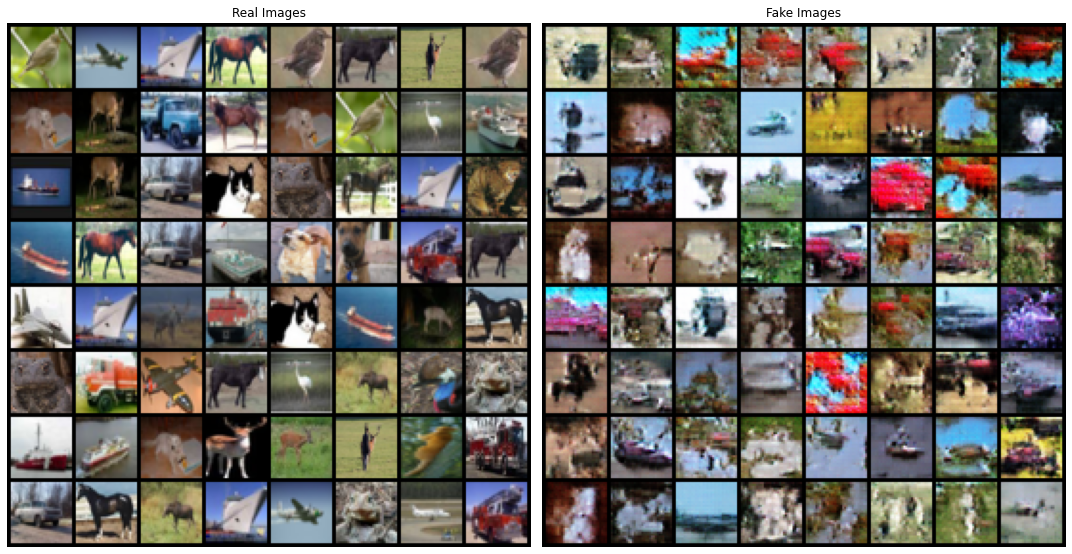

In [13]:
_, axs = plt.subplots(1,2,figsize=(15,15))
display_images(dataset.train_loader,ax = axs[0], max_idx=64)
display_images(img_list, ax = axs[1], max_idx=64)
plt.tight_layout()

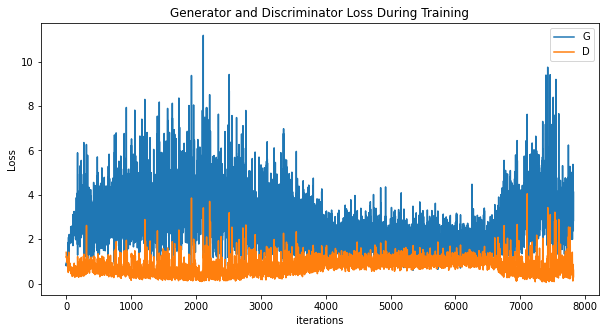

In [14]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Calculating FID Score

In [15]:
from utils.torch_fid_score import get_fid

In [16]:
stat_path = Path('fid_stats/cifar_10_valid_fid_stats.npz')
score = get_fid(Gen, latent_dims, 10000, 256, stat_path)
print(f"\nFID score: {score}")

Propagating batch 100/100
done

FID score: 101.26986694335938


In [18]:
# rc('animation', html='jshtml')
# fig = plt.figure(figsize=(8,8))
# plt.axis("off")
# ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
# ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)
# ani